In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


small dataset - Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

In [5]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
#tags = pd.read_csv("ml-latest-small/tags.csv")
#links = pd.read_csv("ml-latest-small/links.csv")


In [4]:
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.shape

(9742, 3)

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
ratings.shape


(100836, 4)

In [7]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [8]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


<BarContainer object of 19 artists>

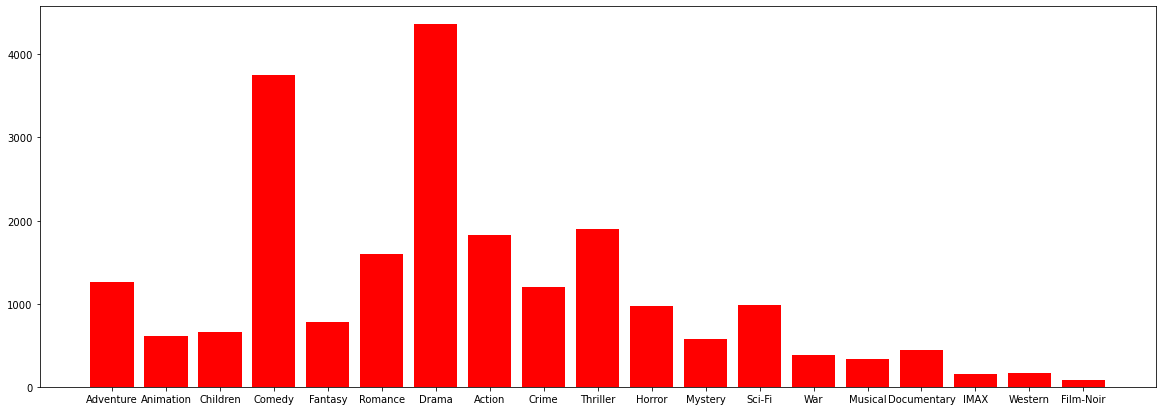

In [10]:
#Most popular genres of movie released

plt.figure(figsize=(20,7))
generlist = movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='r')

D:\ML_DL_projects\movie_recommandation\env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

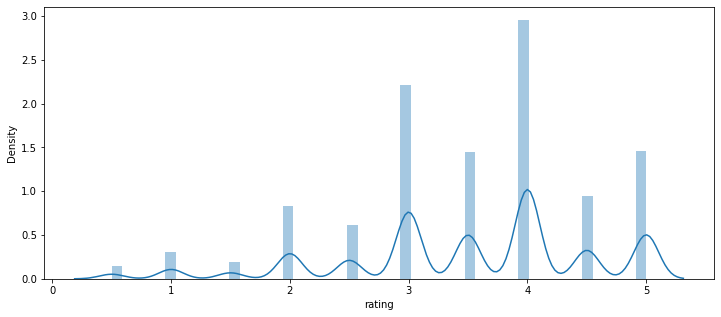

In [15]:
# Distribution of users rating

plt.figure(figsize=(12,5))
sns.distplot(ratings["rating"])

In [16]:
merge_dataset = pd.merge(ratings, movies, on='movieId', how='inner')

In [17]:
merge_dataset

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [18]:
merge_dataset = merge_dataset.drop('timestamp', axis=1)

In [19]:
merge_dataset.shape


(100836, 5)

In [20]:
merge_dataset.nunique()

userId      610
movieId    9724
rating       10
title      9719
genres      951
dtype: int64

In [21]:
ratings_grouped_by_users = merge_dataset.groupby('userId').agg([np.size, np.mean])

In [22]:
ratings_grouped_by_users

movieId                rating          
          size          mean    size      mean
userId                                        
1          232   1854.603448   232.0  4.366379
2           29  70350.275862    29.0  3.948276
3           39   7058.384615    39.0  2.435897
4          216   1982.129630   216.0  3.555556
5           44    343.840909    44.0  3.636364
...        ...           ...     ...       ...
606       1115   9692.197309  1115.0  3.657399
607        187   1860.636364   187.0  3.786096
608        831   4502.605295   831.0  3.134176
609         37    483.162162    37.0  3.270270
610       1302  49590.231183  1302.0  3.688556

[610 rows x 4 columns]

<AxesSubplot:xlabel='userId'>

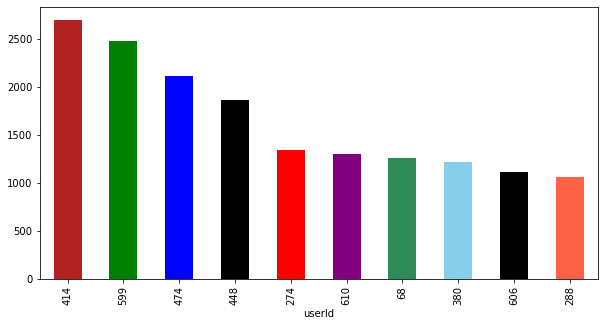

In [26]:
# Top 10 users who have rated most of the movies
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind='bar', figsize = (10,5), color=['firebrick', 'green', 'blue', 'black', 'red',
                    'purple', 'seagreen', 'skyblue', 'black', 'tomato'])

In [27]:
ratings_grouped_by_movies = merge_dataset.groupby('movieId').agg([np.mean], np.size)

In [29]:
ratings_grouped_by_movies

,userId,rating
,mean,mean
movieId,,
1,306.530233,3.920930
2,329.554545,3.431818
3,283.596154,3.259615
4,219.857143,2.357143
5,299.571429,3.071429
...,...,...
193581,184.000000,4.000000
193583,184.000000,3.500000


In [37]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

In [38]:
ratings_grouped_by_movies

,rating
,mean
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000


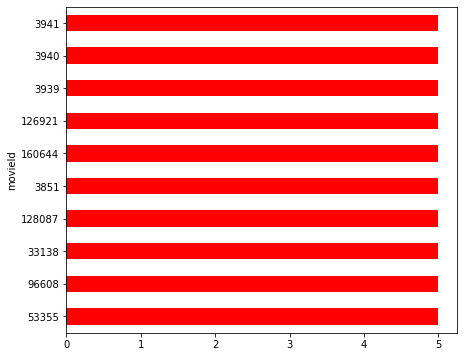

In [39]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6), color='r');

In [40]:
# Movies with low average rating
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [41]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

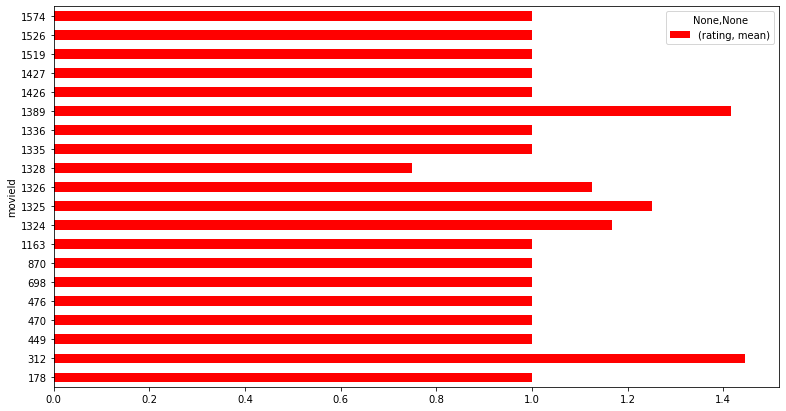

In [42]:
low_rated_movies.head(20).plot(kind='barh', figsize=(13,7), color='r');

In [23]:
#average rating
avg_rat = merge_dataset
avg_rat = avg_rat.groupby('title')['rating'].mean()
avg_rat

title
'71 (2014)                                   4.000000
'Hellboy': The Seeds of Creation (2004)      4.000000
'Round Midnight (1986)                       3.500000
'Salem's Lot (2004)                          5.000000
'Til There Was You (1997)                    4.000000
                                               ...   
eXistenZ (1999)                              3.863636
xXx (2002)                                   2.770833
xXx: State of the Union (2005)               2.000000
¡Three Amigos! (1986)                        3.134615
À nous la liberté (Freedom for Us) (1931)    1.000000
Name: rating, Length: 9719, dtype: float64

In [30]:
sorted_rating = avg_rat.sort_values(ascending = False) 

In [31]:
sorted_rating

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
                                                ... 
The Beast of Hollow Mountain (1956)              0.5
Follow Me, Boys! (1966)                          0.5
The Butterfly Effect 3: Revelations (2009)       0.5
The Emoji Movie (2017)                           0.5
Rust and Bone (De rouille et d'os) (2012)        0.5
Name: rating, Length: 9719, dtype: float64

In [32]:
count_rat = merge_dataset.groupby('title')['rating'].count()

In [33]:
count_rat

title
'71 (2014)                                    1
'Hellboy': The Seeds of Creation (2004)       1
'Round Midnight (1986)                        2
'Salem's Lot (2004)                           1
'Til There Was You (1997)                     2
                                             ..
eXistenZ (1999)                              22
xXx (2002)                                   24
xXx: State of the Union (2005)                5
¡Three Amigos! (1986)                        26
À nous la liberté (Freedom for Us) (1931)     1
Name: rating, Length: 9719, dtype: int64

In [35]:
new_view_dataset = pd.DataFrame()
new_view_dataset['avarage_rating'] = avg_rat
new_view_dataset['count_no_rating'] = count_rat

In [36]:
new_view_dataset

,avarage_rating,count_no_rating
title,,
'71 (2014),4.000000,1
'Hellboy': The Seeds of Creation (2004),4.000000,1
'Round Midnight (1986),3.500000,2
'Salem's Lot (2004),5.000000,1
'Til There Was You (1997),4.000000,2
...,...,...
eXistenZ (1999),3.863636,22
xXx (2002),2.770833,24
xXx: State of the Union (2005),2.000000,5


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [39]:
new_view_dataset.columns

Index(['avarage_rating', 'count_no_rating'], dtype='object')

<AxesSubplot:>

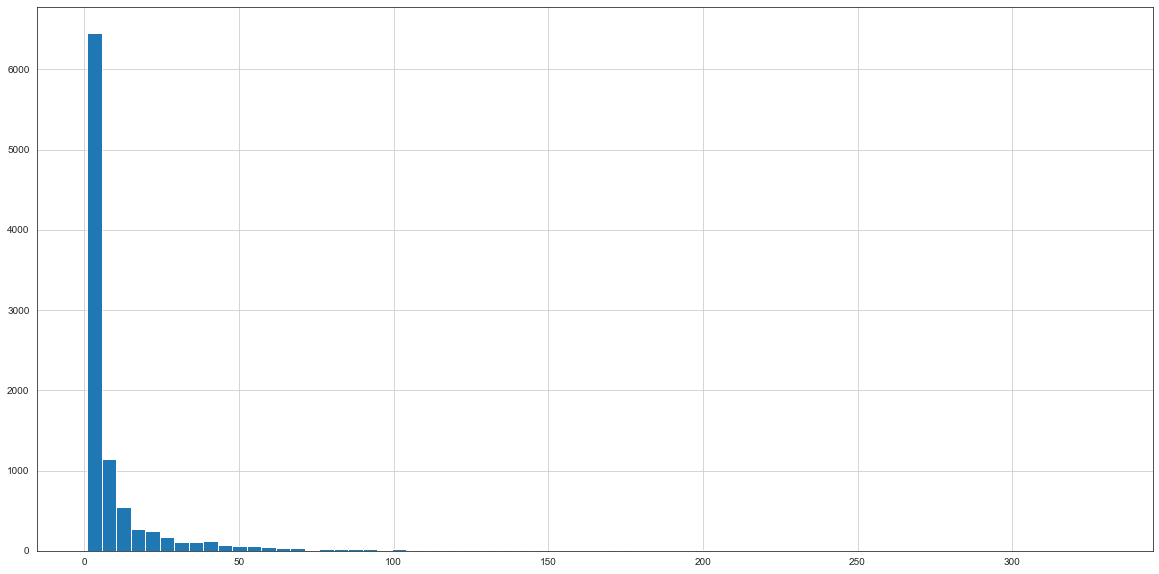

In [48]:
#plot the graph of number of ratings
plt.figure(figsize=(20,10))
new_view_dataset['count_no_rating'].hist(bins = 70)

not that many movies has more than 50 ratings

<AxesSubplot:>

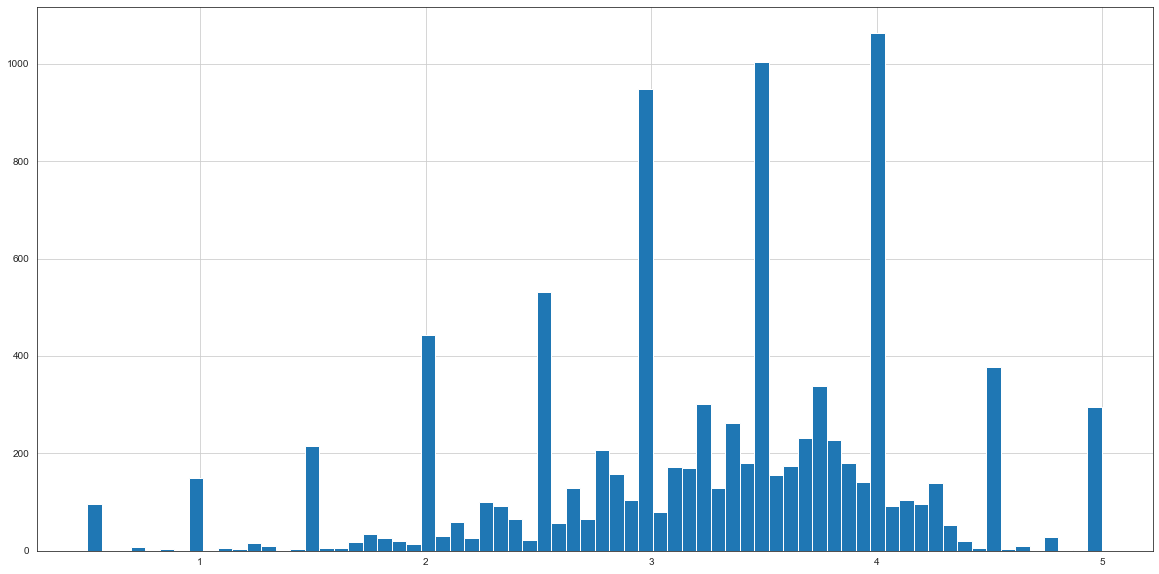

In [47]:
#plot the graph of "rating"
plt.figure(figsize=(20,10))
new_view_dataset['avarage_rating'].hist(bins = 70)

not that many movie has more than  4.5 and less than 2 star rating

crosstabulation between movie_id and User_id from "ratings"

In [45]:
new_ratings = ratings.pivot(index='movieId',columns='userId',values='rating')
new_ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


replacing NaN with 0 

In [46]:
new_ratings.fillna(0,inplace=True)
new_ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
new_ratings.shape

(9724, 610)

In [58]:
# saving a copy to apply into another model
ratings_matrix_items = new_ratings

# recommandation system based on popularity and genre.

The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience.

This model does not give personalized/user based recommendations based on the user.

### reducing the noise by adding some filters...
* To qualify a movie, a minimum of 10 users should have voted a movie.
* To qualify a user, a minimum of 40 movies should have voted by the user.

In [49]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

visualizing the number of users who voted with our limit 10.

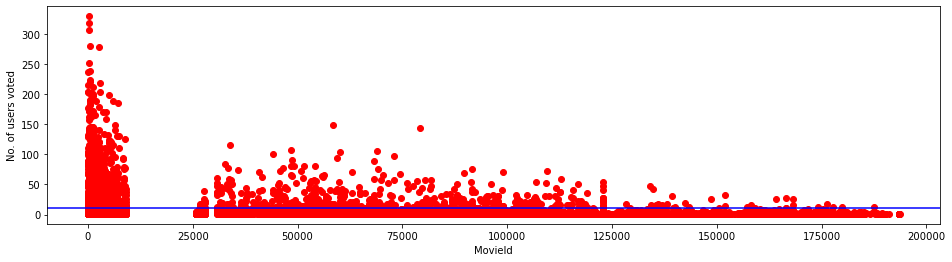

In [50]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='red')
plt.axhline(y=10,color='blue')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

removing movies which didn't satisfy our limit 10 ratings

before filters

In [51]:
new_ratings

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
new_ratings = new_ratings.loc[no_user_voted[no_user_voted > 10].index,:]

visualizing the number of movies which was voted our limit 40.

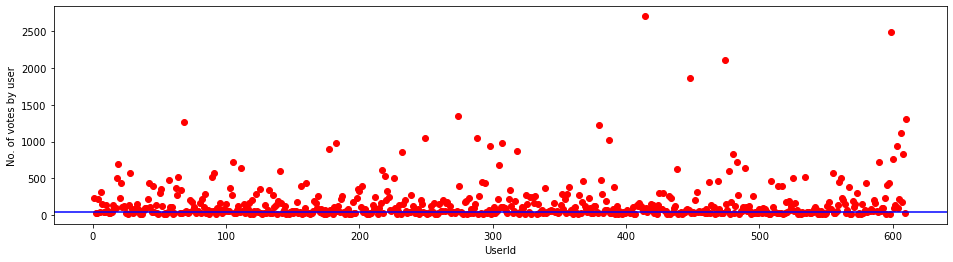

In [53]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='red')
plt.axhline(y=40,color='blue')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

#### removing movies which didn't satisfy our limit 40 ratings

In [139]:
new_ratings = new_ratings.loc[:,no_movies_voted[no_movies_voted > 40].index]

after fiters

In [140]:
new_ratings

userId,1,4,5,6,7,8,9,10,11,14,...,600,601,602,603,604,605,606,607,608,610
0,4.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To reduce the sparsity we use the csr_matrix function from the scipy library.

In [141]:
csr_data = csr_matrix(new_ratings.values)
new_ratings.reset_index(inplace=True)

In [142]:
new_ratings

userId,index,1,4,5,6,7,8,9,10,11,...,600,601,602,603,604,605,606,607,608,610
0,0,4.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,1,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,2,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,3,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,4,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,2116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2117,2117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2118,2118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2119,2119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## modeling with KKN

We first check if the movie name input is in the database and if it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 10 movies with their distances from the input movie.

In [143]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [60]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = new_ratings[new_ratings['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = new_ratings.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

## Recommending

In [61]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,District 9 (2009),0.381027
2,Guardians of the Galaxy (2014),0.379761
3,Kung Fu Panda (2008),0.375980
4,Batman Begins (2005),0.372033
5,Watchmen (2009),0.370870
6,Avatar (2009),0.326285
7,WALL·E (2008),0.315061
8,Iron Man 2 (2010),0.310027
9,"Dark Knight, The (2008)",0.308411
10,"Avengers, The (2012)",0.294442


In [62]:
get_movie_recommendation('Avengers')

,Title,Distance
1,Matilda (1996),0.593354
2,"Haunting, The (1999)",0.578944
3,Mercury Rising (1998),0.568688
4,Speed 2: Cruise Control (1997),0.567220
5,Reindeer Games (2000),0.564510
6,Snake Eyes (1998),0.563339
7,William Shakespeare's A Midsummer Night's Drea...,0.548800
8,Anaconda (1997),0.507164
9,"Edge, The (1997)",0.502303
10,Sphere (1998),0.464465


In [63]:
get_movie_recommendation('Hulk')

,Title,Distance
1,Star Wars: Episode II - Attack of the Clones (...,0.529540
2,X-Men Origins: Wolverine (2009),0.527455
3,"League of Extraordinary Gentlemen, The (a.k.a....",0.523099
4,Spider-Man 2 (2004),0.487364
5,Spider-Man (2002),0.484673
6,Hellboy (2004),0.483697
7,X2: X-Men United (2003),0.469658
8,Fantastic Four (2005),0.442947
9,Daredevil (2003),0.412769
10,"Incredible Hulk, The (2008)",0.403415


# user-genre relation based filtering

In [121]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
movies['genres'] = movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [128]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = movies.loc[movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

In [129]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                         Four Rooms (1995)
18     Ace Ventura: When Nature Calls (1995)
58                           Bio-Dome (1996)
61                             Friday (1995)
79                        Black Sheep (1996)
90                          Mr. Wrong (1996)
92                      Happy Gilmore (1996)
104           Steal Big, Steal Little (1995)
108            Flirting With Disaster (1996)
113                    Down Periscope (1996)
Name: title, dtype: object

In [133]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = ratings[ratings["userId"]== userId]
    for key, row in  df_rating_filtered.iterrows():
        movie_list.append((movies["title"][row["movieId"]==movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)


In [134]:
get_recommendation_content_model(1)

{'*batteries not included (1987)',
 '101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '10th Kingdom, The (2000)',
 '13 Going on 30 (2004)',
 '39 Steps, The (1935)',
 '48 Hrs. (1982)',
 '5,000 Fingers of Dr. T, The (1953)',
 '52 Pick-Up (1986)',
 '7th Voyage of Sinbad, The (1958)',
 '8MM (1999)',
 'A Million Ways to Die in the West (2014)',
 'A Wrinkle in Time (2018)',
 'Above the Rim (1994)',
 'Absolute Power (1997)',
 'Ace Ventura: When Nature Calls (1995)',
 'Action Jackson (1988)',
 'Adventures in Babysitting (1987)',
 'Adventures of Baron Munchausen, The (1988)',
 'Adventures of Buckaroo Banzai Across the 8th Dimension, The (1984)',
 'Adventures of Ichabod and Mr. Toad, The (1949)',
 'Adventures of Pinocchio, The (1996)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Adventures of Sharkboy and Lavagirl 3-D, The (2005)',
 'Agent Cody Banks (2003)',
 'Air Force One (1997)',
 'Aladdin (1992)',
 'Alamo, The (1960)',
 'Alaska (1996)',
 'Alice (1990)',
 'Alice in Wonderla

# Model evaluation with KNN

Here the model is evaluated on based of if there is exact match of genres with the genres of movie which is already watch by user

In [135]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [137]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
#                 print(colums["genres"])
#                 print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.8776739889139807
Fault:0.1223260110860193


# based on User's history making prediction of ratings

In [23]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd=SVD()


## SVD: evalution

In [24]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8749  0.8759  0.8767  0.8715  0.8742  0.8746  0.0018  
MAE (testset)     0.6716  0.6742  0.6739  0.6692  0.6713  0.6720  0.0018  
Fit time          3.50    3.51    3.53    3.51    3.51    3.51    0.01    
Test time         0.19    0.10    0.17    0.10    0.17    0.15    0.04    


{'test_rmse': array([0.87494171, 0.87591108, 0.87666968, 0.87149773, 0.87417575]),
 'test_mae': array([0.67159744, 0.67417337, 0.6739036 , 0.66922294, 0.6713353 ]),
 'fit_time': (3.500293731689453,
  3.510716438293457,
  3.527679443359375,
  3.5141196250915527,
  3.5056395530700684),
 'test_time': (0.1939084529876709,
  0.09976625442504883,
  0.16556048393249512,
  0.10076546669006348,
  0.16608190536499023)}

In [25]:
trainset = data.build_full_trainset()
svd.fit(trainset)

## making prediction

In [32]:
ratings[ratings['userId'] == 77]

,userId,movieId,rating,timestamp
12383,77,260,5.0,1535107459
12384,77,1196,5.0,1535107474
12385,77,1198,5.0,1535107476
12386,77,1210,5.0,1535107480
12387,77,2571,5.0,1535107478
12388,77,3578,5.0,1535107514
12389,77,3948,3.0,1535107573
12390,77,3996,5.0,1535107543
12391,77,4226,2.5,1535107521
12392,77,4878,1.0,1535107550


Now let's use SVD to predict the rating that User with ID 77 will give to a random movie (let's say with Movie ID 7153).

In [36]:
svd.predict(77, 7153)

Prediction(uid=77, iid=7153, r_ui=None, est=4.5209136665309915, details={'was_impossible': False})

For movie with ID 77, we get an estimated prediction of 4.52. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

Now let's use SVD to predict the rating that User with ID 150 will give to a random movie (let's say with Movie ID 1994).

In [37]:
svd.predict(420, 9999)

Prediction(uid=420, iid=9999, r_ui=None, est=3.5722460820363993, details={'was_impossible': False})

For movie with ID 420, I get an estimated prediction of 3.572246. The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## SVD++ : evalution

In [48]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [50]:
# Use movielens-100K
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.15)

type(data)

surprise.dataset.DatasetAutoFolds

In [51]:
algo_svdpp = SVDpp(n_factors=160, n_epochs=10, lr_all=0.005, reg_all=0.1)
algo_svdpp.fit(trainset)
test_pred = algo_svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVDpp : Test Set
RMSE: 0.9410


0.9409712053501393

In [41]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [40]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [43]:
import surprise